In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import copy
from torch.utils.data import DataLoader,  TensorDataset
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn import linear_model
from sklearn import model_selection
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import dc_library as dcl

In [126]:
table = dcl.load_table(savic_features = False, have_images = True)
table = table[table["label"] == 2]
variability_columns = [i for i in table.columns if i.startswith("lc")]
table.drop(columns = variability_columns, inplace = True)


table has 446487 sources
class
Gal         246225
Star         96715
Qso          83130
Agn           5608
highZQso      1089
Name: count, dtype: int64
Keeping 432767 labeled sources
Keeping 432397 with available cutouts


In [127]:
variability_columns = [i for i in table.columns if i.startswith("lc")]
table.drop(columns = variability_columns, inplace = True)
error_columns = [i for i in table.columns if "Err" in i]
table.drop(columns = error_columns, inplace = True)
flux_columns = [i for i in table.columns if "Flux" in i]
table.drop(columns = flux_columns, inplace = True)
other_columns = ['ra', 'dec', 'psPm_ra', 'psPm_dec', 'psParallax',
                'flags_u', 'flags_g', 'flags_r', 'flags_i',
               'flags_z', 'flags_y', 'spec_fiberid', 'spec_plate', 'spec_mjd', 
                 'class', 'label', 'photoZ_pest']
other_columns = [i for i in table.columns if i in other_columns]

table.drop(columns = other_columns, inplace = True)

table.dropna(how = "any", inplace = True)

In [128]:
#dropping objects without spec redshift
print(len(table))
table = table[~np.isnan(table["z"])]
print(len(table))

71088
71088


In [129]:
redshift_bins, Nbins = dcl.get_bins(table['z'].to_numpy(), N_bins = 20)

(array([3555., 3549., 3560., 3554., 3554., 3555., 3554., 3554., 3555.,
        3554., 3554., 3555., 3554., 3554., 3555., 3554., 3547., 3551.,
        3563., 3557.]),
 array([-4.31673900e-04,  5.68048860e-01,  7.52000000e-01,  8.87119200e-01,
         1.00616100e+00,  1.11096600e+00,  1.21223400e+00,  1.30711780e+00,
         1.39685740e+00,  1.48916815e+00,  1.58299600e+00,  1.67558875e+00,
         1.77261660e+00,  1.87167860e+00,  1.97652070e+00,  2.09188850e+00,
         2.21503620e+00,  2.36700000e+00,  2.54400000e+00,  2.81000000e+00,
         7.01124500e+00]),
 <BarContainer object of 20 artists>)

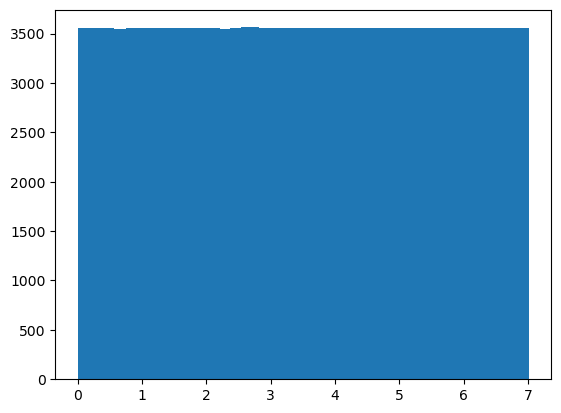

In [130]:
plt.hist(table['z'], bins = redshift_bins)

In [131]:
table["redshift_bin"] = np.digitize(table['z'], bins = redshift_bins)-1

In [132]:
X = table.drop(columns=["z", "redshift_bin"])
y = table["redshift_bin"].to_numpy().astype('int32')
objectID = table.index
X, y, objectID = shuffle(X, y, objectID, random_state = 2605)

In [133]:
X_train, X_test, y_train, y_test, objectID_train, objectID_test, redshift_train, redshift_test = train_test_split(X, y, 
                                objectID, table['z'], test_size = 0.5, random_state = 1406)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
display(X_train.shape, X_test.shape)

(35544, 24)

(35544, 24)

In [134]:
images_train = dcl.load_images(objectID_train, as_tensor = True)
images_test = dcl.load_images(objectID_test, as_tensor = True)

In [135]:
X_train, y_train = dcl.transform2tensor(X_train, y_train)
X_test, y_test = dcl.transform2tensor(X_test, y_test)

In [136]:
class model_tabular(nn.Module):
    def __init__(self):
        super(model_tabular, self).__init__()
        
        self.tabular_savic_like = nn.Sequential(
                     nn.Linear(24, 24),
                     nn.ReLU(),
                     nn.Linear(24, 15))
        
    def forward(self, x):
        return self.tabular_savic_like(x)
    
class model_images(nn.Module):
    
    def __init__(self):
        super(model_images, self).__init__()
        
        self.dense_part = nn.Sequential(
                          nn.Linear(3*8*8, 30),
                          nn.ReLU(),
                          nn.Linear(30, 30))
        
    def forward(self, x):
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = self.dense_part(x)
        return x
    
    
    

    
class combined_model(nn.Module):
    
    def __init__(self):
        super(combined_model,self).__init__()
        
        self.model_tabular = model_tabular()
        self.model_images = model_images()
        self.dense = nn.Linear(45, 20)
        
    def forward(self, images, tabular):
        
        images =  self.model_images(images)
        tabular = self.model_tabular(tabular)
        out = torch.concat([images, tabular], dim = 1)
        out = self.dense(out)
        return out 

In [137]:
summary(combined_model(), input_size =[(1,3,16,16), (1,24)])

Layer (type:depth-idx)                   Param #
├─model_tabular: 1-1                     --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  600
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  375
├─model_images: 1-2                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-4                  5,790
|    |    └─ReLU: 3-5                    --
|    |    └─Linear: 3-6                  930
├─Linear: 1-3                            920
Total params: 8,615
Trainable params: 8,615
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─model_tabular: 1-1                     --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  600
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  375
├─model_images: 1-2                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-4                  5,790
|    |    └─ReLU: 3-5                    --
|    |    └─Linear: 3-6                  930
├─Linear: 1-3                            920
Total params: 8,615
Trainable params: 8,615
Non-trainable params: 0

In [138]:
train_dataset = TensorDataset(images_train, X_train, y_train)
test_dataset = TensorDataset(images_test, X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [139]:
def train_routine(dataloader, model,  loss_fn, optimizer):
    losses = []
    num_batches = len(dataloader)
    for batch, (images, tabular, labels) in enumerate(dataloader): #X[0] = tensor with features, X[1] = labels
        output = model(images, tabular)
        loss = loss_fn(output, labels)

        # Backpropagation
        optimizer.zero_grad()    # Clear the gradient
        loss.backward()          # Compute the gradient (??)
        optimizer.step()         # update model weights

        
        if batch == round(num_batches/2):
            losses.append(loss.item())

    return losses

def test_routine(dataloader, model, loss_fn, verbose = True):
    num_batches = len(dataloader)
    test_loss = 0
    model.eval() 
    with torch.no_grad():
        for images, tabular, labels in dataloader:
            output = model(images, tabular)
            test_loss += loss_fn(output, labels).item()

    test_loss /= num_batches
    model.train()
    if verbose:
        print(f" Avg test loss      : {test_loss:>8f}")

    return test_loss

    

In [140]:
modello_finale = combined_model()
EPOCHS = 150
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(modello_finale.parameters(), lr=0.001)

In [141]:
train_loss = []
test_loss  = []
for t in range(EPOCHS):
    train_loss.append(train_routine(train_dataloader, modello_finale, loss_fn, optimizer))
    test_loss.append(test_routine(test_dataloader, modello_finale, loss_fn, verbose = True))
    print(f"Epoch {t}")
print("Done!")

 Avg test loss      : 2.988603
Epoch 0
 Avg test loss      : 2.972391
Epoch 1
 Avg test loss      : 2.952650
Epoch 2
 Avg test loss      : 2.929628
Epoch 3
 Avg test loss      : 2.906880
Epoch 4
 Avg test loss      : 2.886144
Epoch 5
 Avg test loss      : 2.865943
Epoch 6
 Avg test loss      : 2.844918
Epoch 7
 Avg test loss      : 2.822509
Epoch 8
 Avg test loss      : 2.798330
Epoch 9
 Avg test loss      : 2.772765
Epoch 10
 Avg test loss      : 2.746338
Epoch 11
 Avg test loss      : 2.719308
Epoch 12
 Avg test loss      : 2.691273
Epoch 13
 Avg test loss      : 2.661599
Epoch 14
 Avg test loss      : 2.629635
Epoch 15
 Avg test loss      : 2.594891
Epoch 16
 Avg test loss      : 2.556977
Epoch 17
 Avg test loss      : 2.515757
Epoch 18
 Avg test loss      : 2.471093
Epoch 19
 Avg test loss      : 2.423144
Epoch 20
 Avg test loss      : 2.371942
Epoch 21
 Avg test loss      : 2.317808
Epoch 22
 Avg test loss      : 2.261381
Epoch 23
 Avg test loss      : 2.203353
Epoch 24
 Avg test 

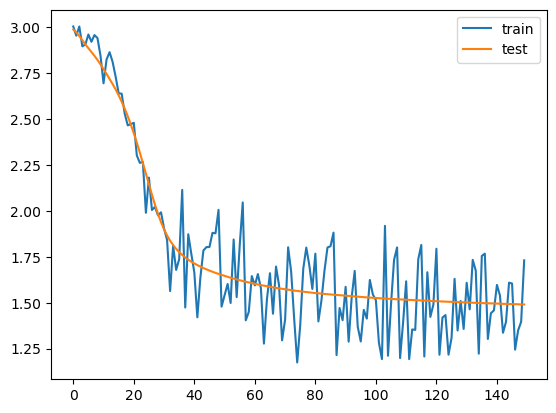

In [142]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, EPOCHS,1), train_loss, label = "train")
ax.plot(np.arange(0, EPOCHS,1), test_loss, label = "test")
ax.legend()

[0.81169196 0.64801343 0.60351673 0.49150623 0.49830891 0.3042735
 0.274455   0.30949657 0.34236726 0.50203134 0.48059867 0.22070845
 0.14544426 0.49245388 0.37647721 0.57014085 0.53797101 0.57221915
 0.52526374 0.71839729]
0.4709655638082377


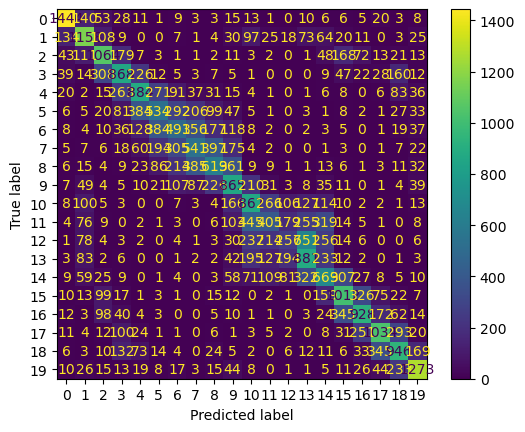

In [143]:
with torch.no_grad():
    predictions = modello_finale(images_test, X_test)
    predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_test, predictions)

accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test, predictions))
ConfusionMatrixDisplay(cf).plot()


In [144]:
from scipy.stats import gaussian_kde

In [145]:
xy = np.vstack([y_test, predictions])
density = gaussian_kde(xy)(xy)

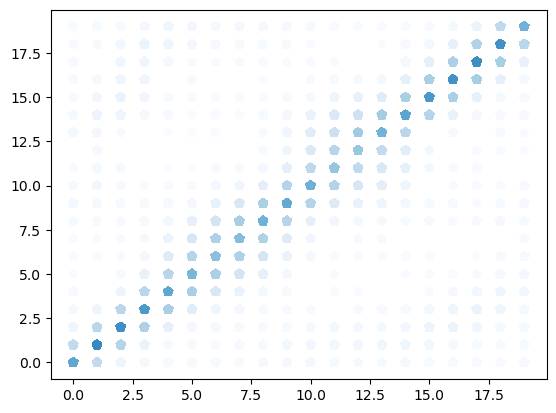

In [148]:
cmap = 'Blues'
vmin, vmax = 0.00, 0.03
fig, ax = plt.subplots()
ax.scatter(y_test,predictions, c=density, cmap=cmap, marker ='p', vmin=vmin, vmax=vmax,s=40)

In [149]:
redshift_from_labels = [(i+j)/2 for i, j in zip(redshift_bins[:-1],redshift_bins[1:])] 
zpredictions = [redshift_from_labels[i] for i in predictions]


xy = np.vstack([redshift_test, zpredictions])
density = gaussian_kde(xy)(xy)



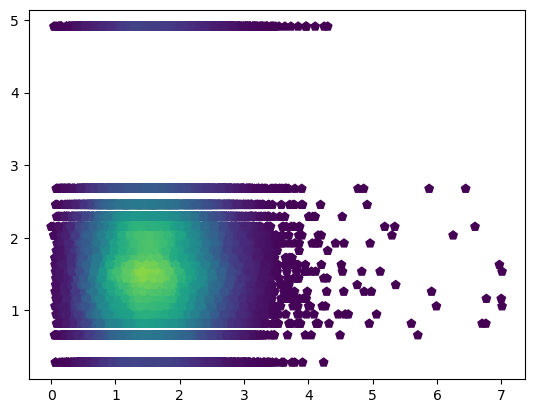

In [150]:
cmap = 'viridis'
vmin, vmax = 0.00, 0.35
fig, ax = plt.subplots()
ax.scatter(redshift_test, zpredictions,  c=density, cmap=cmap, marker ='p', vmin=vmin, vmax=vmax,s=40 )

In [151]:
idx = redshift_test < 3
true_test = redshift_test[idx]
pred_test = np.array(zpredictions)[idx]

(array([  17.,   63.,  126.,  170.,  250.,  247.,  239.,  201.,  162.,
         168.,  199.,  335.,  657., 1053., 1626., 2122., 2646., 3167.,
        3550., 3493., 3341., 2978., 2442., 1956., 1452.,  911.,  581.,
         266.,  123.,   43.]),
 array([-4.86665425, -4.61395939, -4.36126454, -4.10856968, -3.85587483,
        -3.60317997, -3.35048512, -3.09779026, -2.84509541, -2.59240055,
        -2.3397057 , -2.08701084, -1.83431599, -1.58162113, -1.32892628,
        -1.07623142, -0.82353657, -0.57084171, -0.31814686, -0.065452  ,
         0.18724285,  0.43993771,  0.69263257,  0.94532742,  1.19802228,
         1.45071713,  1.70341199,  1.95610684,  2.2088017 ,  2.46149655,
         2.71419141]),
 <BarContainer object of 30 artists>)

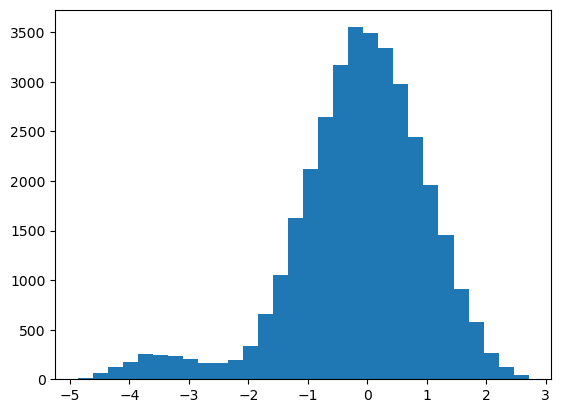

In [152]:
plt.hist(true_test-pred_test, bins = 30)